In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PartI.valueIteration.local_functions import *

trial: None with psi0=0, psi1=0
Converged after 354 iterations.
trial: Fixed with psi0=0, psi1=0.1
Converged after 319 iterations.
trial: Smooth with psi0=0.01, psi1=0
Converged after 385 iterations.


[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Max Rel Difference'), None]

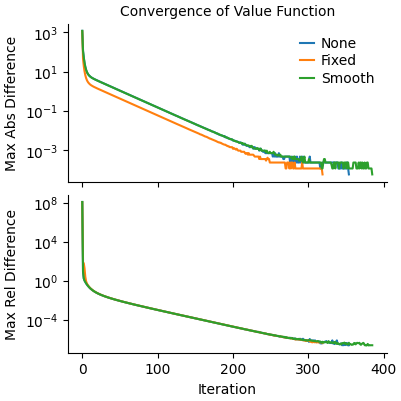

In [2]:
max_iter = 1000
n_z, n_k, pow_bound = 101, 101, 15
rho = 0.7
sigma = 0.15
m = 6
delta = 0.15
r = 0.04
theta = 0.7

trials = {'None': (0, 0), 'Fixed': (0, 0.1), 'Smooth': (0.01, 0)}
V_tables = {} # To store (V_table, lnz_vals, k_vals) tuple for each trial

fig, ax = plt.subplots(2, figsize=(4,4), sharex='all')
for trial, (psi0, psi1) in trials.items():
    print(f'trial: {trial} with psi0={psi0}, psi1={psi1}')
    ret = value_iteration(max_iter, n_z, n_k, pow_bound, psi0=psi0, psi1=psi1, 
                          rho=rho, sigma=sigma, m=m, delta=delta, r=r, theta=theta)
    V_table, lnz_vals, k_vals, max_diff, rel_diff = ret
    V_tables[trial] = (V_table, lnz_vals, k_vals)

    np.savez(f'value_iteration_{trial}.npz', V_table=V_table.numpy(), 
             lnz_vals=lnz_vals.numpy(), k_vals=k_vals.numpy())

    ax[0].plot(max_diff.numpy(), label=f'{trial}')
    ax[1].plot(rel_diff.numpy(), label=f'{trial}')

ax[0].legend()
ax[0].set(ylabel='Max Abs Difference', title='Convergence of Value Function', yscale='log')
ax[1].set(xlabel='Iteration', ylabel='Max Rel Difference', yscale='log')

[Text(0.5, 0, 'capital stock $k$'), Text(0, 0.5, 'exogenous shock $z$')]

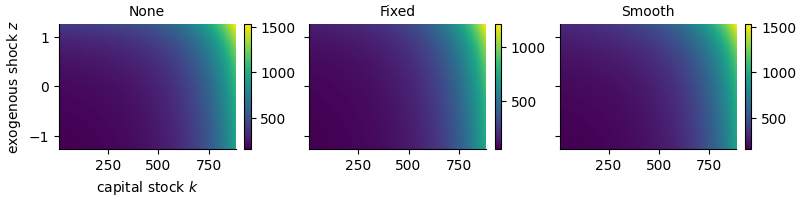

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharex='all', sharey='all')
for i, trial in enumerate(trials.keys()):
    im = ax[i].imshow(V_tables[trial][0].numpy(), origin='lower', aspect='auto', 
                      extent=[k_vals[0], k_vals[-1], lnz_vals[0], lnz_vals[-1]])
    fig.colorbar(im, ax=ax[i])
    ax[i].set(title=trial)
ax[0].set(xlabel='capital stock $k$', ylabel='exogenous shock $z$')

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(81.09405, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(19.721209, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(81.09405, shape=(), dtype=float32)


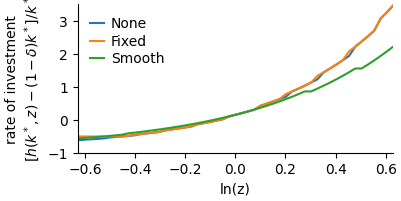

In [4]:
fig, ax = plt.subplots(1, figsize=(4,2))
for trial, (ps0, ps1) in trials.items():
    Pz, lnz_vals = AR1_transition_matrix(n_z)
    lnz_idx = tf.argmin(tf.abs(lnz_vals))
    k = value_function(k_vals, lnz_vals[lnz_idx,None], k_vals, 
                       V_tables[trial][0], Pz[lnz_idx,None,:], 
                       psi0=trials[trial][0], psi1=trials[trial][1], 
                       delta=delta, r=r, theta=theta)[1]
    # print(k)
    diff = tf.abs(k - k_vals)
    min_diff, k_ss = tf.reduce_min(diff), k_vals[tf.argmin(diff)]
    print(min_diff, k_ss)

    _, k_next = value_function(k_ss[None], lnz_vals, k_vals, V_tables[trial][0], Pz,
                               psi0=trials[trial][0], psi1=trials[trial][1], 
                               delta=delta, r=r, theta=theta)
    ax.plot(lnz_vals, k_next / k_ss - (1 - 0.15), label=trial)
    # print(k_next / k_ss - (1 - 0.15))
ax.set(xlim=[-0.63, 0.63], ylim=[-1, 3.5], xlabel='ln(z)', 
       ylabel='rate of investment\n' + r'$[h(k^*,z) - (1 - \delta) k^*] / k^*$')
ax.legend()

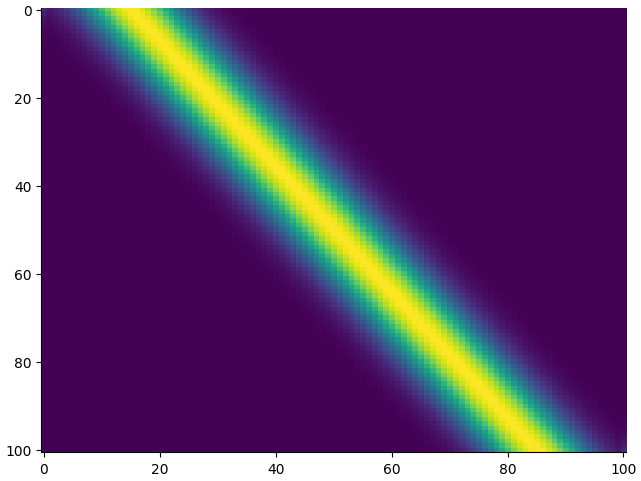

In [5]:
Pz, lnz_vals = AR1_transition_matrix(n_z, rho=rho, sigma=sigma, m=m)
plt.imshow(Pz)